## Dataset used: "Carbonmonitor Europe Data"
https://figshare.com/articles/dataset/Carbon_Monitor_Europe_a_near-real-time_and_country-level_monitoring_of_daily_CO2_emissions_for_European_Union_and_the_United_Kingdom/20219024

This dataset is about daily CO2 emissions across European countries, broken down by economic sectors, over several years (from ~2019 to 2026 in your version).
As our first step we gona start by importing libraries we will use:
##### pandas, seaborn and matplotlib

### Problem Definition / Research Questions:
* RQ 1: How did COVID-19 lockdowns affect CO2 emissions across Europe, especially in transport and aviation sectors?
* RQ 2: Which countries consistently emit the most CO2, and how do their sectoral emission profiles differ?
* RQ 3: Which sectors cause most of the changes in emissions over time?

In [4]:
# Import Statements

import pandas as pd
import seaborn as sns
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

Next is to load the dataset we are going to use and checking what it includes inside:

In [5]:
# Load in dataset

carbon_df = pd.read_csv('data/carbonmonitor-eu_datas.csv')
carbon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431334 entries, 0 to 431333
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   country     431334 non-null  object 
 1   date        431334 non-null  object 
 2   sector      431334 non-null  object 
 3   value       431334 non-null  float64
 4   Unnamed: 4  0 non-null       float64
dtypes: float64(2), object(3)
memory usage: 16.5+ MB


As we can see there are 4 unique columns and one EMPTY column "Unnamed: 4", so the next thing we gona do is deleting empty column and converting the Dtype of the "date" column into more appropriate "datetime" form so we can divide it into years, months and days respectively for further manipulations:

In [6]:
# Deleting "Unnamed: 4" column with .drop function
carbon_df.drop('Unnamed: 4',axis= 1, inplace=True)

# Converting object into datatime and separating the column
carbon_df['date'] = pd.to_datetime(carbon_df['date'], errors='coerce')  
carbon_df['year'] = carbon_df['date'].dt.year
carbon_df['month'] = carbon_df['date'].dt.month
carbon_df['day'] = carbon_df['date'].dt.day

By using pandas "grouby" function we can get total amount of CO2 emissioned by country per day and use this information to calculate how much percent of total CO2 emission is caused by specific country in certain sector.

In [7]:
# Grouping carbon_df coulumns "country" and "date", and summing the "value" elements

carbon_df['Total Country Daily'] = carbon_df.groupby(['country', 'date'])['value'].transform('sum')
carbon_df['Sector Share Percent'] = 100 * carbon_df['value'] / carbon_df['Total Country Daily']
carbon_df['Total Country'] = carbon_df.groupby('country')['value'].transform('sum')

# Display first 5 rows of our Dataset
carbon_df.head()


,country,date,sector,value,year,month,day,Total Country Daily,Sector Share Percent,Total Country
0,Norway,2019-01-01,Power,0.006542,2019.0,1.0,1.0,0.098426,6.646723,235.441619
1,Norway,2019-02-01,Power,0.005956,2019.0,2.0,1.0,0.095958,6.206455,235.441619
2,Norway,2019-03-01,Power,0.006048,2019.0,3.0,1.0,0.099696,6.066550,235.441619
3,Norway,2019-04-01,Power,0.005940,2019.0,4.0,1.0,0.100088,5.934585,235.441619
4,Norway,2019-05-01,Power,0.005649,2019.0,5.0,1.0,0.096659,5.844528,235.441619


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Graph ploting:

 ### 1. Line Plot – CO2 Emissions in Germany Over Time
It shows daily CO2 emissions in Germany from 2019 to 2026.


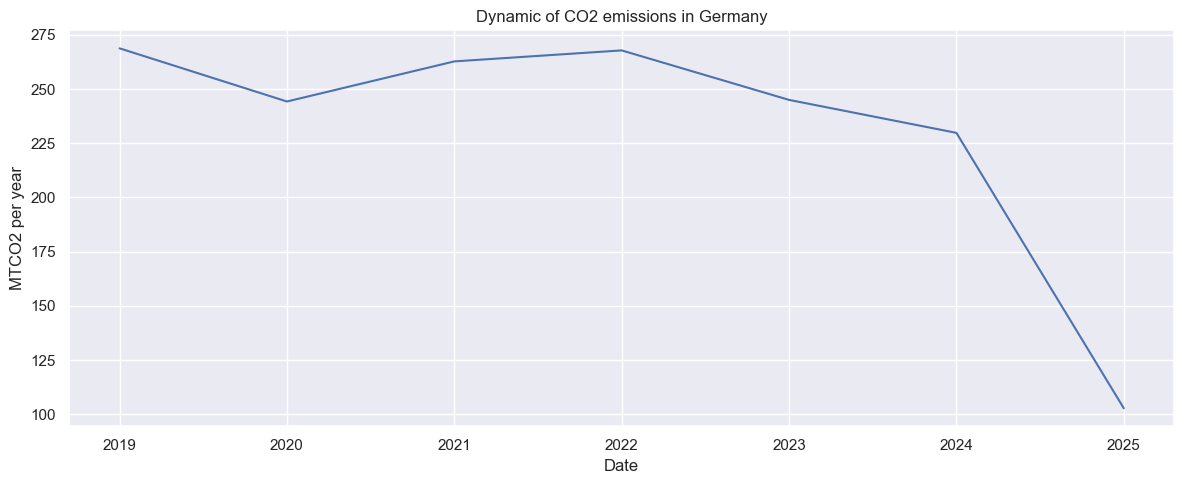

In [8]:
# Filtering the dataset for country == "Germany"
germany_df = carbon_df[carbon_df['country'] == 'Germany']

# Grouping by "year" and summing emissions across sectors
daily_sum = germany_df.groupby('year')['value'].sum()

# Plottign as a line chart with years on the x-axis and million tons of emissions on the y-axis
plt.figure(figsize=(12, 5))
daily_sum.plot()
plt.title("Dynamic of CO2 emissions in Germany")
plt.xlabel("Date")
plt.ylabel("MTCO2 per year")
plt.grid(True)
plt.tight_layout()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 2.Bar Plot – Average Daily Emissions by Country

It compares average daily emissions among top 10 European countries.

And showcases the countries with the highest overall CO2 output.

C:\Users\saidt\AppData\Local\Temp\ipykernel_28296\2209632350.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_avg.values, y=country_avg.index, palette="Reds_r")


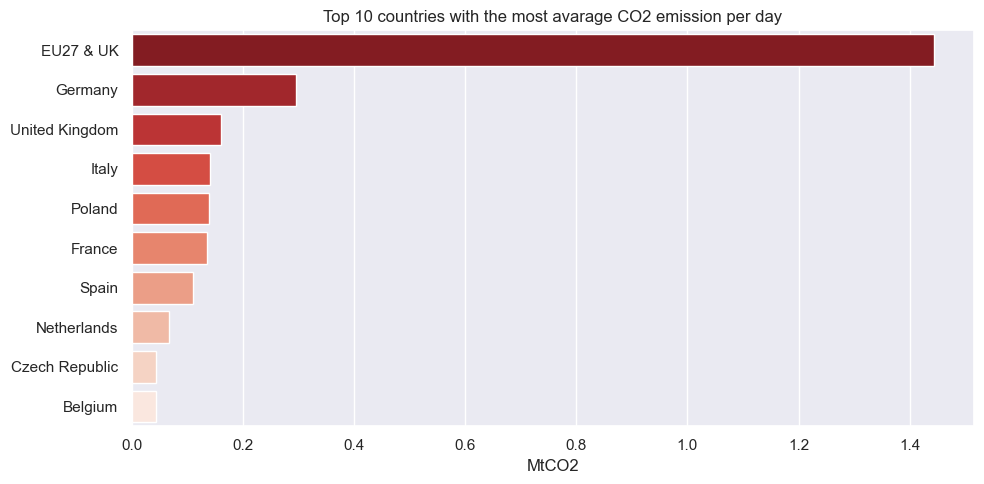

In [9]:
# First we start by grouping by countries and calculating .mean() of value.

country_avg = carbon_df.groupby('country')['value'].mean().sort_values(ascending=False).head(10)

# Then right after we sort and plot the top 10 using a horizontal bar chart.
plt.figure(figsize=(10, 5))
sns.barplot(x=country_avg.values, y=country_avg.index, palette="Reds_r")
plt.title("Top 10 countries with the most avarage CO2 emission per day")
plt.xlabel("MtCO2")
plt.ylabel(None)
plt.tight_layout()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 3.Stacked Area Plot – CO2 Emissions by Sector Over Time

It shows how each sector (Power, Industry, Transport, etc.) contributes to total emissions over time.

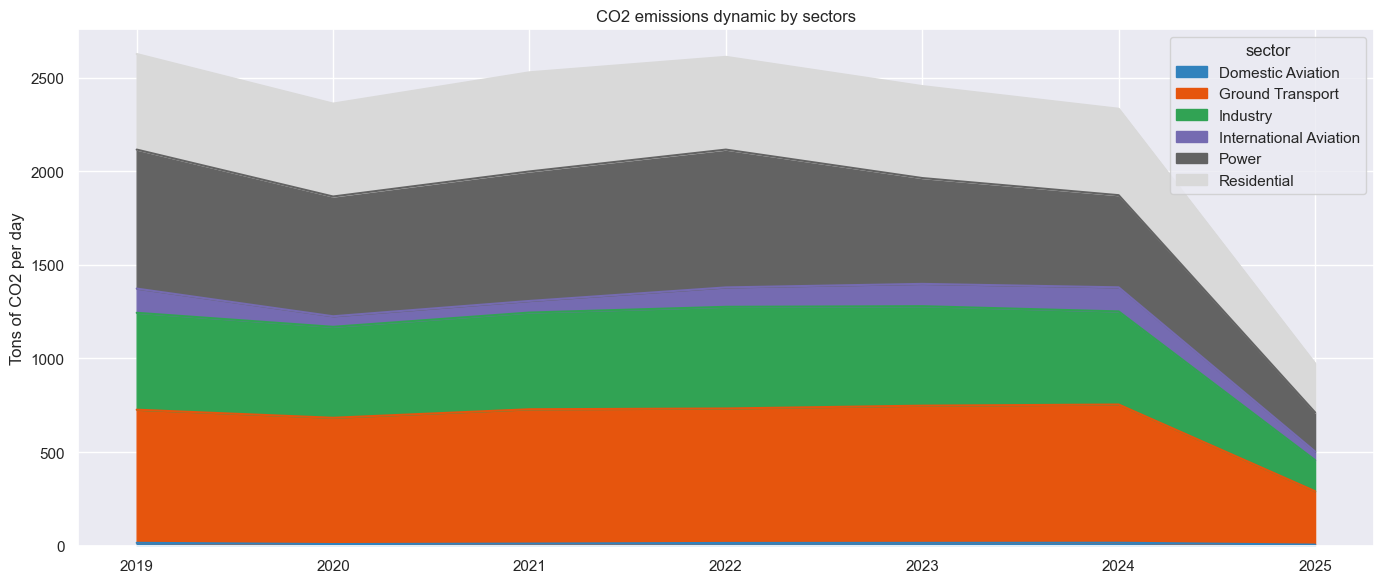

In [12]:
# Using groupby function we group date and sector columns by ['value'] and summarize it to get a pivot table.
pivot = carbon_df.groupby(['year', 'sector'])['value'].sum().unstack()

# Plotting with .plot.area() for a stacked effect.
pivot.plot.area(figsize=(14, 6), colormap='tab20c')
plt.title("CO2 emissions dynamic by sectors")
plt.ylabel("Tons of CO2 per day")
plt.xlabel(None)
plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### 4. Heatmap – Correlation Between Emission Sectors.

This graph's purpose is to visualizes how emissions in one sector correlate with emissions in others.

To be more precise, high correlation means: Sectors rise and fall together, for example Power & Industry.

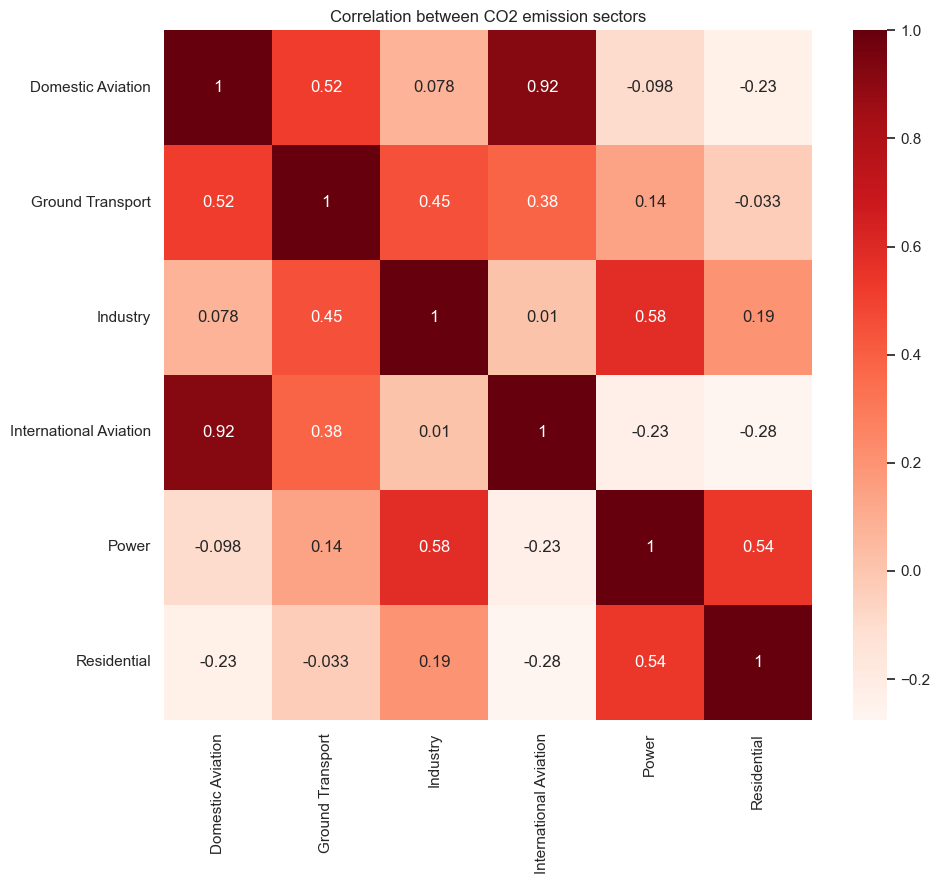

In [11]:
# Creating a pivot table: date as index, sectors as columns.
# And calculating .corr() to get correlation matrix.
pivot = carbon_df.pivot_table(index='date', columns='sector', values='value').corr()

# Plotting with sns.heatmap.
plt.figure(figsize=(10, 9))

# Changing the colour to red and by using 'annot=True' showing values
sns.heatmap(pivot, annot=True, cmap='Reds')
plt.title("Correlation between CO2 emission sectors")
plt.ylabel(None)
plt.xlabel(None)
plt.tight_layout()
#Done


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Answers to the Questions:

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### RQ1. How did COVID-19 lockdowns affect CO2 emissions across Europe, especially in transport and aviation sectors ?
#### Relevant Graphs :

Line plot of daily emissions over time (First graph) and Stacked area plot by sector
#### Answer :
During early 2020 CO2 emissions dropped a lot — especially in transport and aviation. This happened because of the COVID-19 lockdowns: people stayed home, flights were canceled, and fewer cars were on the road.The line charts show this clearly. Emissions started going back up in 2021–2022 as life returned to normal. This tells us that real change needs long-term solutions, not just temporary shutdowns.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### RQ2. Which countries consistently emit the most CO2, and how do their sectoral emission profiles differ ?
#### Relevant Graphs:

Bar plot of average emissions by country (Second graph), Stacked area (Third graph) or heatmap of sectoral differences (Last graph)

#### Answer :
Countries like Germany, France, and Italy produce the most CO2 in Europe. But they do it in different ways: Germany has high emissions from power plants and factories. France has lower power emissions, maybe because it uses more nuclear energy. Italy has a mix — transport and homes also create a lot of emissions. So each country needs its own plan to reduce emissions, depending on what's causing them.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### RQ3. Which sectors cause most of the changes in emissions over time ?
#### Relevant Graphs :
Line plot of daily emissions over time (First graph) and stacked area(Third graph) charts to compare the CO2 emissions from each sector over time.

#### Answer :
The biggest changes come from transport and power sectors. Transport changes a lot when people travel more or less (like during lockdowns). Power depends on how much electricity people use and how it's produced. Residential homes stay more stable and change slowly over time. Aviation dropped a lot in 2020 and is still recovering.

By looking at the graphs, we can see which sectors to focus on first if we want to lower emissions fast.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------